# ***Comparador de Algoritmos: C4.5 vs KNN***

### Para ejecutar ambos algoritmos junto con la interfaz, se debe ejecutar (dentro de esta sección "Comparador de Algoritmos: C4.5 vs KNN") cada sección de código en el órden en el que aparecen. Luego de ejecutar la sección de código referida a la interfaz, en la consola aparecerá un link al cual se puede ingresar para una mejor experiencia, el mismo es donde se aloja la interfaz.

In [ ]:
# @title
!pip install gradio #Instala la librería para ejecutar la interfaz
!pip install gdown #Instala el instalador de archivos en la carpeta temporal de Google Colab
!gdown "https://drive.google.com/uc?id=1Ffvv4lv0AZf9UtSuFPMTn4xalq-nhdmW" #Guarda el archivo de data_cardiovascular_imputado.csv en la carpeta de Google Colab

Downloading...
From: https://drive.google.com/uc?id=1Ffvv4lv0AZf9UtSuFPMTn4xalq-nhdmW
To: /content/data_cardiovascular_imputado.csv
100% 226k/226k [00:00<00:00, 75.1MB/s]


### Estratificador

In [ ]:
# @title
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import csv

def set_fit(path, target_column, testSize=0.3):

    data = pd.read_csv(path)

    # Columna de referencia para estratificar
    stratify_column = data[target_column]

    # Configurar el muestreo estratificado
    split = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=42)

    # Dividir el dataset en 70% para entrenamiento y 30% para prueba
    for train_index, test_index in split.split(data, stratify_column):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

    # Guardar la muestra en un nuevo archivo CSV si lo deseas
    path = path.replace(".csv", "")
    pathTrain = path+"_TrainData.csv"
    pathTest = path+"_TestData.csv"
    train_data.to_csv(pathTrain, index=False)
    test_data.to_csv(pathTest, index=False)

    # Verificar la distribución en cada subconjunto
    print("Distribución en el conjunto de entrenamiento:")
    print(train_data['TenYearCHD'].value_counts(normalize=True))
    print("\nDistribución en el conjunto de prueba:")
    print(test_data['TenYearCHD'].value_counts(normalize=True))

    return pathTrain, pathTest

def sortedCsv(input_csv, output_csv):
    try:
        with open(input_csv, "r") as csv_file:
            reader = csv.reader(csv_file)
            header = next(reader)

            # Mantener la última columna fija y ordenar las demás
            last_column = header[-1]
            columns_to_sort = header[:-1]
            sorted_indices = sorted(range(len(columns_to_sort)), key=lambda i: columns_to_sort[i])
            sorted_header = [columns_to_sort[i] for i in sorted_indices] + [last_column]

            # Reorganizar las filas según el orden de `sorted_indices`, manteniendo la última columna
            sorted_rows = [
                [row[i] for i in sorted_indices] + [row[-1]]
                for row in reader
            ]

        # Escribir el nuevo archivo CSV ordenado
        with open(output_csv, "w", newline="") as sorted_csv_file:
            writer = csv.writer(sorted_csv_file)
            writer.writerow(sorted_header)  # Escribir la cabecera ordenada
            writer.writerows(sorted_rows)   # Escribir las filas reordenadas

        print(f"CSV ordenado y guardado como '{output_csv}'.")

    except Exception as e:
        print(f"Ocurrió un error: {e}")


### C4.5 General

In [ ]:
import math
import csv
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class C45:
	def __init__(self, pathToCsv, gainRatio=False, infoGainThreshold=0.001):
		self.filePathToCsv = pathToCsv
		self.data = []
		self.classes = []
		self.numAttributes = -1
		self.attrValues = {}
		self.original_attributes = []
		self.attributes = []
		self.attributesToRemove = []
		self.attributesToChange = []
		self.tree = None
		self.timeStart = 0
		self.timeTotalFit = 0
		self.timeTotalPredict = 0
		self.infoGainThreshold = infoGainThreshold
		self.gainRatio = gainRatio
		self.y_test = []
		self.y_pred = []
		self.messageError = None
		self.countNodes = 0

	def fetchDataCSV(self):
		try:
			with open(self.filePathToCsv, "r") as file:
				reader = csv.reader(file)
				# Lee la primera fila (nombres de atributos)
				self.attributes = next(reader)
				self.attributes.pop()
				self.numAttributes = len(self.attributes)
				print("---------------------------------")
				print("Atributos:", self.attributes)
				# Lee el resto de los datos
				for row in reader:
					if all(element.strip() for element in row):
						self.data.append(row)

				# Inferir las clases (última columna)
				self.classes = list(set([row[-1] for row in self.data]))
				print("Clases:", self.classes)

				# Inferir los valores posibles de los atributos
				self.inferAttributeValues()
				print("Valores de atributos:", self.attrValues)
				print("---------------------------------")
		except Exception as e:
			self.messageError = "Archivo no encontrado. Por favor, verifique la ruta del archivo CSV."
			raise Exception(self.messageError) from e

	def inferAttributeValues(self):
		for i in range(self.numAttributes):
			column_values = [row[i] for row in self.data]
			try:
				# Se intenta convertir todos los valores a float para determinar si es continuo
				list(map(float, column_values))
				self.attrValues[self.attributes[i]] = ["continuous"]
			except ValueError:
				# Si falla, se considera discreto y se almacenan sus valores únicos
				self.attrValues[self.attributes[i]] = list(set(column_values))

	def preprocessData(self):
		# Verificar si un atributo tiene valores únicos en cada registro
		for attr_index in range(self.numAttributes):
			unique_values = set(row[attr_index] for row in self.data)
			if len(unique_values) == len(self.data):
				self.attributesToRemove.append(attr_index)
			else:
				if not self.isAttrDiscrete(self.attributes[attr_index]) and len(unique_values) == 2:
					# Si el atributo es continuo y tiene solo 2 valores únicos, se convierte a discreto
					unique_values = sorted(list(unique_values))
					self.attributesToChange.append([attr_index, unique_values])

		for attr in self.attributesToChange:
			attr_index = attr[0]
			unique_values = attr[1]
			print(f"Convirtiendo atributo continuo a discreto: {self.attributes[attr_index]}")
			for index, row in enumerate(self.data):
				if self.data[index][attr_index] == list(unique_values)[0]:
					self.data[index][attr_index] = "NO ("+str(list(unique_values)[0])+")"
				else:
					self.data[index][attr_index] = "SI ("+str(list(unique_values)[1])+")"
			self.attrValues[self.attributes[attr_index]] = [f"NO ({unique_values[0]})", f"SI ({unique_values[1]})"]
		print(f"Valores de atributos actualizados: {self.attrValues}")
		print("---------------------------------")

		# Eliminar los atributos únicos de cada registro y actualizar la lista de atributos
		for index in sorted(self.attributesToRemove, reverse=True):
			for row in self.data:
				del row[index]
			print(f"Eliminando atributo único: {self.attributes[index]}")
			del self.attrValues[self.attributes[index]]
			del self.attributes[index]
			self.numAttributes -= 1

  		# Convertir valores a float para atributos no discretos
		for index, row in enumerate(self.data):
			for attr_index in range(self.numAttributes):
				if not self.isAttrDiscrete(self.attributes[attr_index]):
					self.data[index][attr_index] = float(self.data[index][attr_index])

	def printTree(self):
		self.printNode(self.tree)

	def printNode(self, node, indent=""):
		if not node.isLeaf:
			if node.threshold is None:
				# Cuando un atributo es discreto, el threshold del nodo es None
				for index,child in enumerate(node.children):
					if child.isLeaf:
						print(indent + node.label + " = " + self.attrValues[node.label][index] + " : " + child.label)
					else:
						print(indent + node.label + " = " + self.attrValues[node.label][index] + " : ")
						self.printNode(child, indent + "	")
			else:
				# Cuando un atributo es continuo, el threshold del nodo es un valor numérico que es el punto medio entre dos valores adyacentes
				leftChild = node.children[0]
				rightChild = node.children[1]
				if leftChild.isLeaf:
					print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
				else:
					print(indent + node.label + " <= " + str(node.threshold)+" : ")
					self.printNode(leftChild, indent + "	")

				if rightChild.isLeaf:
					print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
				else:
					print(indent + node.label + " > " + str(node.threshold) + " : ")
					self.printNode(rightChild , indent + "	")
		else:
			# Esto sucede cuando el arbol es un único nodo hoja
			print(indent + "Nodo con clase: " + node.label)

	def generateTree(self):
		self.timeStart = time.time()
		print("Generando árbol...")
		# Se llama a la función recursiva para generar el árbol
		self.tree = self.recursiveGenerateTree(self.data, self.attributes)
		self.timeTotalFit = time.time() - self.timeStart
		print("Árbol generado en ",self.timeTotalFit," segundos.")
		print("Cantidad de nodos: ", self.countNodes)

	def recursiveGenerateTree(self, curData, curAttributes):
		if len(curData) == 0:
			#Fail
			return Node(True, "Fail", None)
		else:
			allSame = self.allSameClass(curData)
			if allSame is not False:
				# Retorna un nodo con la clase a la que pertenecen todos los datos
				self.countNodes += 1
				return Node(True, allSame, None)
			elif len(curAttributes) == 0:
				# Retorna un nodo con la clase mayoritaria
				majClass = self.getMajClass(curData)
				self.countNodes += 1
				return Node(True, majClass, None)
			else:
				(best,best_threshold,splitted) = self.splitAttribute(curData, curAttributes)
				remainingAttributes = curAttributes[:]
				if best != -1: # Existe un atributo para particionar
					node = Node(False, best, best_threshold)
					node.children = []
					if best_threshold is None and best != -1:
         				# El atributo es discreto, por lo que se lo remueve de la lista de atributos restantes de esa rama
						remainingAttributes.remove(best)
					# Se llama recursivamente a la función para cada subconjunto del atributo (son 2 si es continuo)
					for subset in splitted:
						child = self.recursiveGenerateTree(subset, remainingAttributes)
						node.children.append(child)
					self.countNodes += 1
					return node
				else: # No se puede particionar por ningun atributo de los restantes (la ganancia es menor al umbral)
					# Retorna un nodo con la clase mayoritaria
					majClass = self.getMajClass(curData)
					self.countNodes += 1
					return Node(True, majClass, None)

	def getMajClass(self, curData):
		# Retorna la clase mayoritaria de un conjunto de datos
		freq = [0]*len(self.classes)
		for row in curData:
			index = self.classes.index(row[-1])
			freq[index] += 1
		if freq[0] == freq[1]:
			return '1'
		maxInd = freq.index(max(freq))
		return self.classes[maxInd]

	def allSameClass(self, data):
		# Retorna la clase si todos los datos pertenecen a la misma clase, False en caso contrario
		for row in data:
			if row[-1] != data[0][-1]:
				return False
		return data[0][-1]

	def isAttrDiscrete(self, attribute):
		# Retorna True si el atributo es discreto, False si es continuo
		if attribute not in self.attributes:
			raise ValueError("Attribute not listed")
		elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
			return False
		else:
			return True

	def splitAttribute(self, curData, curAttributes):
		splitted = []
		minGan = self.infoGainThreshold
		best_attribute = -1
		# Se inicializa el mejor umbral en None, el cual permanecerá así si el atributo es discreto
		best_threshold = None
		for attribute in curAttributes:
			indexOfAttribute = self.attributes.index(attribute)
			if self.isAttrDiscrete(attribute):
				# Se divide el conjunto de datos en n-subconjuntos, donde n es la cantidad de valores diferentes
    			# del atributo i. Se elige el atributo con la ganancia máxima
				valuesForAttribute = self.attrValues[attribute]
				subsets = [[] for a in valuesForAttribute]
				for row in curData:
					for index in range(len(valuesForAttribute)):
						if row[indexOfAttribute] == valuesForAttribute[index]:
							subsets[index].append(row)
							break
				g = self.gain(curData, subsets)
				if g > minGan:
					minGan = g
					splitted = subsets
					best_attribute = attribute
					best_threshold = None
			else:
				# Se ordenan los datos según la columna. Luego se prueban todos los pares adyacentes posibles.
    			# Se divide el conjunto de datos en dos subconjuntos, donde el umbral es el punto medio entre
    			# dos valores adyacentes. Se elige el atributo con la ganancia máxima
				curData.sort(key = lambda x: x[indexOfAttribute])
				for j in range(0, len(curData) - 1):
					if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
         				# Si no son iguales se puede dividir en ese punto medio entre los dos valores
						threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
						less = []
						greater = []
						for row in curData:
							if(row[indexOfAttribute] > threshold):
								greater.append(row)
							else:
								less.append(row)
						g = self.gain(curData, [less, greater])
						if g >= minGan:
							splitted = [less, greater]
							minGan = g
							best_attribute = attribute
							best_threshold = threshold
				# Esto se realiza cuando todos los valores del atributo continuo son iguales y no encuentra una particion para el atributo
				if 0 >= minGan:
					splitted = [curData, []]
					minGan = 0
					best_attribute = attribute
					best_threshold = curData[0][indexOfAttribute]
		return (best_attribute,best_threshold,splitted)

	def gain(self, unionSet, subsets):
		# Entrada: conjunto de datos y subconjuntos disjuntos
    	# Salida: ganancia de información o tasa de ganancia, de acuerdo a la configuración
		S = len(unionSet)

     	# Calcular la impureza antes de la división
		impurityBeforeSplit = self.entropy(unionSet)

     	# Calcular la impureza después de la división
		weights = [len(subset)/S for subset in subsets]
		impurityAfterSplit = 0
		for i in range(len(subsets)):
			impurityAfterSplit += weights[i]*self.entropy(subsets[i])

  		# Calcular la ganancia de información total
		totalGain = impurityBeforeSplit - impurityAfterSplit

		if self.gainRatio == False:
			return totalGain

		# Si se está utilizando la tasa de ganancia, se calcula el split info
  		# Calcular la entropía de partición (split info)
		splitInfo = -sum(weight * math.log2(weight) for weight in weights if weight > 0)
		# Calcular la tasa de ganancia
		gainRatio = totalGain / splitInfo if splitInfo != 0 else 0
		return gainRatio

	def entropy(self, dataSet):
		# Calcular la entropía de un conjunto de datos
		S = len(dataSet)
		if S == 0:
			return 0
		num_classes = [0 for i in self.classes]
		for row in dataSet:
			classIndex = list(self.classes).index(row[-1])
			num_classes[classIndex] += 1
		num_classes = [x/S for x in num_classes]
		ent = 0
		for num in num_classes:
			ent += num*self.log(num)
		return ent*-1

	def log(self, x):
		# Calcular el logaritmo en base 2 de x
		if x == 0:
			return 0
		else:
			return math.log(x,2)

	def loadDataToPredict(self, path_to_test_csv):
		try:
			# Cargar los datos de prueba de un csv
			self.test_data = []
			with open(path_to_test_csv, "r") as file:
				reader = csv.reader(file)
				attributesTest = next(reader)  # Saltar la fila de cabecera si existe ya que solo se necesita la data
				"""if attributesTest != self.attributes:
					self.messageError = "Los atributos del conjunto de prueba no coinciden con los del conjunto de entrenamiento."
					raise ValueError(self.messageError)"""
				for row in reader:
					if all(element.strip() for element in row):
						self.test_data.append(row)

			for attr in self.attributesToChange:
				attr_index = attr[0]
				unique_values = attr[1]
				for index, row in enumerate(self.test_data):
					if self.test_data[index][attr_index] == list(unique_values)[0]:
						self.test_data[index][attr_index] = "NO ("+str(list(unique_values)[0])+")"
					else:
						self.test_data[index][attr_index] = "SI ("+str(list(unique_values)[1])+")"

			# Se eliminan los atributos únicos de cada registro y se actualiza la lista de atributos,
			# para que al hacer la predicción recorriendo el árbol no haya errores
			for index in sorted(self.attributesToRemove, reverse=True):
				for row in self.test_data:
					del row[index]

		except Exception as e:
			self.messageError = "Ocurrió un error al cargar los datos de prueba."
			raise Exception(self.messageError) from e


	def calculateAccuracy(self, total_instances_0, total_instances_1, correct_predictions_0, correct_predictions_1, predictions_0, predictions_1):
		# Calcular la precisión del modelo en el conjunto de prueba
		accuracy = (correct_predictions_0+correct_predictions_1) / (total_instances_0+total_instances_1)
		if predictions_0 == 0:
			accuracy_0 = 0
		else:
			accuracy_0 = correct_predictions_0 / predictions_0
		if predictions_1 == 0:
			accuracy_1 = 0
		else:
			accuracy_1 = correct_predictions_1 / predictions_1
		if total_instances_0 == 0:
			recall_0 = 0
		else:
			recall_0 = correct_predictions_0 / total_instances_0
		if total_instances_1 == 0:
			recall_1 = 0
		else:
			recall_1 = correct_predictions_1 / total_instances_1
		return accuracy, accuracy_0, accuracy_1, recall_0, recall_1

	def predict(self, instance, node=None):
		# Predice la clase de una instancia recorriendo el árbol
		if node is None: # Comienza desde la raíz, esto solo se llama la primera vez
			node = self.tree
		if node.isLeaf: # Si es un nodo hoja, retorna la clase
			return node.label
		else: # Si no es un nodo hoja, sigue recorriendo el árbol
			attr_index = self.attributes.index(node.label)
			attr_value = instance[attr_index]
			if node.threshold is None:
				# Atributo discreto
				for i, child in enumerate(node.children):
					if self.attrValues[node.label][i] == attr_value:
						return self.predict(instance, child)
			else:
				# Atributo continuo
				if float(attr_value) <= node.threshold:
					return self.predict(instance, node.children[0])
				else:
					return self.predict(instance, node.children[1])

	def makePredictions(self):
		try:
			if self.tree is None:
				self.messageError = "El árbol no ha sido generado. Por favor, genere el árbol antes de realizar predicciones."
				raise ValueError(self.messageError)
			# Realiza predicciones en el conjunto de prueba
			self.timeStart = time.time()
			correct_predictions_0 = 0
			correct_predictions_1 = 0
			predictions_0 = 0
			predictions_1 = 0
			total_instances_0 = 0
			total_instances_1 = 0
			self.y_test = []
			self.y_pred = []
			for instance in self.test_data:
				actual_class = instance[-1]  # El último valor es la clase
				self.y_test.append(actual_class)
				predicted_class = self.predict(instance)
				self.y_pred.append(predicted_class)
				if predicted_class == "0": # Cantidad de predicciones de 0
					predictions_0 += 1
				else:                   # Cantidad de predicciones de 1
					predictions_1 += 1
				if actual_class == "0":     # Cantidad de instancias de 0
					total_instances_0 += 1
				else:                   # Cantidad de instancias de 1
					total_instances_1 += 1
				if actual_class == predicted_class:
					if actual_class == "0": # Predicciones correctas de 0
						correct_predictions_0 += 1
					else:                   # Predicciones correctas de 1
						correct_predictions_1 += 1
			self.timeTotalPredict = time.time() - self.timeStart
			print("Predicción realizada en ",self.timeTotalPredict," segundos.")
			accuracy, accuracy_0, accuracy_1, recall_0, recall_1 = self.calculateAccuracy(total_instances_0, total_instances_1, correct_predictions_0, correct_predictions_1, predictions_0, predictions_1)
			count = 0
			for i in range(len(self.y_test)):
				if self.y_pred[i] is None:count +=1
			print("Cantidad de predicciones nulas: ",count)
			return total_instances_0, total_instances_1, accuracy, accuracy_0, accuracy_1, recall_0, recall_1
		except Exception as e:
			if self.messageError is None:
				self.messageError = "Ocurrió un error al realizar las predicciones."
			raise Exception(self.messageError) from e

	def confusionMatrixC45(self, filename="confusion_matrix_c45.png"):
		# Calcula la matriz de confusión
		conf_matrix = confusion_matrix(self.y_test, self.y_pred)
		plt.figure(figsize=(8, 6))
		sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18})
		if self.gainRatio == True:
			plt.title(f"Matriz de Confusión\nDT Usando tasa de ganancia de información mínima = {self.infoGainThreshold}")
		else:
			plt.title(f"Matriz de Confusión\nDT Usando ganancia de información mínima = {self.infoGainThreshold}")
		plt.xlabel('Predicción', fontsize=18)
		plt.ylabel('Etiqueta Real', fontsize=18)
		plt.xticks(fontsize=16)
		plt.yticks(fontsize=16)
		plt.savefig(filename)  #Esto guarda la imágen en lugar de mostrarla
		plt.close() #Cierra la figura y libera memoriaa
		return filename #Acá se devuelve la ruta absoluta de la imágen

'''   def confusionMatrixC45(self):
		# Calcula la matriz de confusión
		conf_matrix = confusion_matrix(self.y_test, self.y_pred)
		plt.figure(figsize=(8, 6))
		sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18})
		plt.title(f"Matriz de Confusión -  DT con ganancia mínima = {self.infoGainThreshold}")
		plt.xlabel('Predicción', fontsize=18)
		plt.ylabel('Etiqueta Real', fontsize=18)
		plt.xticks(fontsize=16)
		plt.yticks(fontsize=16)
		plt.show() '''

class Node:
	def __init__(self,isLeaf, label, threshold):
		self.label = label
		self.threshold = threshold
		self.isLeaf = isLeaf
		self.children = []

### Main del C4.5

In [ ]:
path = "data_cardiovascular_imputado.csv"
sortedCsv(input_csv=path, output_csv="data_cardiovascular_imputado_sorted.csv")
pathTrain, pathTest = set_fit(path="data_cardiovascular_imputado_sorted.csv", target_column="TenYearCHD", testSize=0.3)

def ejecutar_c45(use_gain_ratio, threshold):
  try:
      c2 = C45(pathToCsv=pathTrain, gainRatio=use_gain_ratio, infoGainThreshold=threshold)
      c2.fetchDataCSV()
      c2.preprocessData()
      c2.generateTree()
      #c2.printTree()
      c2.loadDataToPredict(path_to_test_csv=pathTest)
      total_instances_0, total_instances_1, accuracy, accuracy_0, accuracy_1, recall_0, recall_1 = c2.makePredictions()
      print(f"Total de instancias en el conjunto de prueba: {total_instances_0+total_instances_1}")
      print(f"Total de instancias de la clase 0 en el conjunto de prueba: {total_instances_0}")
      print(f"Total de instancias de la clase 1 en el conjunto de prueba: {total_instances_1}")
      print(f"Precisión del modelo en el conjunto de prueba: {accuracy * 100:.2f}%")
      print(f"Precisión del modelo en el conjunto de prueba para la clase 0 (Sensibilidad): {accuracy_0 * 100:.2f}%")
      print(f"Precisión del modelo en el conjunto de prueba para la clase 1 (Sensibilidad): {accuracy_1 * 100:.2f}%")
      print(f"Recall de la clase 0: {recall_0}")
      print(f"Recall de la clase 1: {recall_1}")
      matrix_img_path = c2.confusionMatrixC45(filename="confusion_matrix_c45.png")
      return accuracy, accuracy_0, accuracy_1, c2.timeTotalFit, c2.timeTotalPredict, c2.timeTotalFit+c2.timeTotalPredict, recall_0, recall_1, matrix_img_path
  except Exception as e:
      print(e)

CSV ordenado y guardado como 'data_cardiovascular_imputado_sorted.csv'.
Distribución en el conjunto de entrenamiento:
TenYearCHD
0    0.849136
1    0.150864
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
TenYearCHD
0    0.849558
1    0.150442
Name: proportion, dtype: float64


### KNN

In [ ]:
import pandas as pd
import numpy as np #calculos matemáticos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import csv
import pickle
import time  # Importar para medir tiempo

# 1. Cargar el archivo CSV
#data = pd.read_csv('/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado.csv')
def ejecutar_knn(chosen_k):
    data = pd.read_csv("data_cardiovascular_imputado_sorted.csv")

    # Crear un archivo de log para guardar filas con problemas
    log_filename = 'log_errores.csv'
    logfile = open(log_filename, mode='w', newline='')
    logwriter = csv.writer(logfile)
    logwriter.writerow(['Fila', 'Error'])  # Escribir encabezado en el archivo de log

    # 2. Limpiar y procesar los datos con manejo de errores
    data_clean = []
    for idx, row in data.iterrows():
        try:
            # Convertir variables categóricas a numéricas
            row['sex'] = 1 if row['sex'] == 'M' else 0
            row['is_smoking'] = 1 if row['is_smoking'] == 'YES' else 0
            if row.isnull().any():  # Verificar si hay datos faltantes
                raise ValueError("Datos faltantes en la fila")
            data_clean.append(row)
        except Exception as e:
            logwriter.writerow([idx, str(e)])  # Registrar el error en el log
            continue  # Continuar con la siguiente fila

    logfile.close()  # Cerrar el archivo de log

    # Convertir la lista data_clean en un DataFrame
    data_clean = pd.DataFrame(data_clean)

    # 3. Definir características y variable objetivo
    X = data_clean[['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
                    'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
                    'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]
    y = data_clean['TenYearCHD']

    # 4. Dividir en conjunto de entrenamiento y prueba usando estratificación
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 5. Normalizar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Implementación del algoritmo KNN desde cero

    def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    class KNN:
        def __init__(self, k):
            self.k = k

        def set_k(self, new_k):
            """Método para actualizar el valor de k."""
            if new_k <= 0:
                raise ValueError("k debe ser un entero positivo.")
            self.k = new_k
            print(f"Nuevo valor de k: {self.k}")

        def train(self, X_train, y_train):
            self.X_train = X_train
            self.y_train = y_train

        def predict(self, X_test):
            predictions = [self._predict(x) for x in X_test]
            return np.array(predictions)

        def _predict(self, x):
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train.iloc[i] for i in k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)
            return most_common[0][0]

    # 7. Crear una instancia de KNN con k=3
    knn = KNN(chosen_k)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    knn.train(X_train_scaled, y_train)
    end_train = time.time()
    train_duration = end_train - start_train
    print(f"\nTiempo de entrenamiento: {train_duration:.4f} segundos")

    # Medir el tiempo de predicción
    start_predict = time.time()
    y_pred = knn.predict(X_test_scaled)
    end_predict = time.time()
    predict_duration = end_predict - start_predict
    print(f"Tiempo de predicción: {predict_duration:.4f} segundos")

    # Evaluar el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\nPrecisión del modelo KNN: {accuracy:.2f}')

    # 11. Mostrar y guardar la matriz de confusión
    def confusionMatrixKNN(filename="confusion_matrix_knn.png"):
        conf_matrix = confusion_matrix(y_test, y_pred)
        # Crear la figura y el heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, annot_kws={"size": 18})
        # Configurar los títulos y etiquetas
        ax.set_title(f'Matriz de Confusión - KNN con valor de k = {chosen_k}')
        ax.set_xlabel('Predicción', fontsize=18)
        ax.set_ylabel('Etiqueta Real', fontsize=18)
        # Guardar la figura como JPG
        fig.savefig('matriz_confusion_knn.jpg', format='jpg', bbox_inches='tight')
        print("\nMatriz de Confusión guardada exitosamente como 'matriz_confusion_knn.jpg'.")
        # Mostrar la figura en pantalla
        plt.savefig(filename)
        # Cerrar la figura para liberar memoria
        plt.close(fig)
        return filename
    """ # Guardar un CSV comparativo con el ID de cada ejemplo, y_test y y_pred
    comparacion = pd.DataFrame({
        'ID': y_test.index,                       # Índice original del ejemplo
        'Etiqueta Real (y_test)': y_test.values,  # Etiqueta real
        'Predicción (y_pred)': y_pred             # Predicción del modelo
    })

    # Guardar el DataFrame como CSV
    comparacion.to_csv('/content/comparacion_knn.csv', index=False)
    print("\nArchivo comparacion_knn.csv guardado exitosamente.") """

    # PRECISIÓN Y RECALL
    # Calcular la precisión y el recall por clase
    precision_por_clase = precision_score(y_test, y_pred, average=None)  # Precisión por clase
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Asignar valores de la matriz de confusión
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calcular manualmente el recall por clase
    recall_por_clase = [
        tn / (tn + fp),  # Recall para la clase 0
        tp / (tp + fn)   # Recall para la clase 1
    ]
    # Crear un DataFrame para mostrar las métricas por clase
    metricas_por_clase = pd.DataFrame({
        'Clase': ['Sin Riesgo (0)', 'Con Riesgo (1)'],
        'Precisión': precision_por_clase,
        'Recall': recall_por_clase
    })

    # Mostrar las métricas por clase en pantalla
    print(metricas_por_clase)

    # Guardar el modelo entrenado usando pickle
    """ with open('knn_model.pkl', 'wb') as f:
        pickle.dump(knn, f)
    print("\nModelo KNN guardado exitosamente.") """

    # 13. Verificar la representatividad de los conjuntos
    def verificar_representatividad(nombre, conjunto, y_original):
        print(f"\nVerificación de {nombre}:")
        print("Distribución por clase:")
        print(conjunto.value_counts(normalize=True))
        print(f"Diferencia con la distribución original: {(conjunto.value_counts(normalize=True) - y_original.value_counts(normalize=True)).abs()}")

    verificar_representatividad('Entrenamiento', y_train, y)
    verificar_representatividad('Prueba', y_test, y)

    # MAS METRICAS
    # Crear una lista con todas las métricas y la matriz de confusión
    metricas_knn = {
        'Precisión Global': accuracy_score(y_test, y_pred),
        'Precisión Clase 0 (Sin Riesgo)': precision_por_clase[0],
        'Precisión Clase 1 (Con Riesgo)': precision_por_clase[1],
        'Recall Clase 0 (Sin Riesgo)': recall_por_clase[0],
        'Recall Clase 1 (Con Riesgo)': recall_por_clase[1],
        'Tiempo de Entrenamiento (s)': train_duration,
        'Tiempo de Predicción (s)': predict_duration,
        #'Matriz de Confusión': confusion_matrix(y_test, y_pred).tolist(),  # Convertir matriz a lista para guardarla
    }

    total_time = metricas_knn['Tiempo de Entrenamiento (s)'] + metricas_knn['Tiempo de Predicción (s)']
    matrix_img_path = confusionMatrixKNN(filename="confusion_matrix_knn.png")

    # Mostrar las métricas en pantalla
    print("\nMétricas del Modelo KNN:")
    for etiqueta, valor in metricas_knn.items():
        print(f"{etiqueta}: {valor}")

    return metricas_knn['Precisión Global'], metricas_knn['Precisión Clase 0 (Sin Riesgo)'], metricas_knn['Precisión Clase 1 (Con Riesgo)'], metricas_knn['Tiempo de Entrenamiento (s)'], metricas_knn['Tiempo de Predicción (s)'], total_time, metricas_knn['Recall Clase 0 (Sin Riesgo)'], metricas_knn['Recall Clase 1 (Con Riesgo)'], matrix_img_path

### Interfaz

In [ ]:
import gradio as gr

def ejecutar_algoritmos(tasa_ganancia, threshold, k_elegido):

    accuracy_c45, accuracy_0_c45, accuracy_1_c45, train_time_c45, test_time_c45, total_time_c45, recall_0_c45, recall_1_c45, matrix_img_path_c45 = ejecutar_c45(tasa_ganancia, threshold)
    accuracy_knn, accuracy_0_knn, accuracy_1_knn, train_time_knn, test_time_knn, total_time_knn, recall_0_knn, recall_1_knn, matrix_img_path_knn = ejecutar_knn(k_elegido)

    def mejor(a, b, align_left=False):
        if not align_left:
            return f"<span style='float: right;'>🔼</span>" if a > b else ""
        else:
            return f"<span style='float: left;'>🔼</span>" if a > b else ""

    result_html = f"""
    <h2 style='color: #3498DB;'>Resultados Obtenidos</h2>
    <table style="width:100%; border-collapse: collapse; font-size: 18px;">
      <thead>
        <tr style="background-color: #3d455f; color: white;">
          <th style="width: 25%; border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">Métrica</th>
          <th style="width: 37.5%; border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">C4.5</th>
          <th style="width: 37.5%; padding: 10px; text-align: center;">KNN</th>
        </tr>
      </thead>
      <tbody>
        <tr style="background-color: #2C3E50; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Precisión</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{accuracy_c45 * 100:.2f}%{mejor(accuracy_c45, accuracy_knn)}</td>
          <td style="padding: 10px; text-align: center;">{accuracy_knn * 100:.2f}%{mejor(accuracy_knn, accuracy_c45, align_left=True)}</td>
        </tr>
        <tr style="background-color: #34495E; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Precisión (clase 0)</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{accuracy_0_c45 * 100:.2f}%{mejor(accuracy_0_c45, accuracy_0_knn)}</td>
          <td style="padding: 10px; text-align: center;">{accuracy_0_knn * 100:.2f}%{mejor(accuracy_0_knn, accuracy_0_c45, align_left=True)}</td>
        </tr>
        <tr style="background-color: #2C3E50; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Precisión (clase 1)</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{accuracy_1_c45 * 100:.2f}%{mejor(accuracy_1_c45, accuracy_1_knn)}</td>
          <td style="padding: 10px; text-align: center;">{accuracy_1_knn * 100:.2f}%{mejor(accuracy_1_knn, accuracy_1_c45, align_left=True)}</td>
        </tr>
        <tr style="background-color: #34495E; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Tiempo Entrenamiento</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{train_time_c45:.4f} seg.{mejor(train_time_knn, train_time_c45)}</td>
          <td style="padding: 10px; text-align: center;">{train_time_knn:.4f} seg.{mejor(train_time_c45, train_time_knn, align_left=True)}</td>
        </tr>
        <tr style="background-color: #2C3E50; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Tiempo de Prueba</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{test_time_c45:.4f} seg.{mejor(test_time_knn, test_time_c45)}</td>
          <td style="padding: 10px; text-align: center;">{test_time_knn:.4f} seg.{mejor(test_time_c45, test_time_knn, align_left=True)}</td>
        </tr>
        <tr style="background-color: #34495E; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Tiempo Total</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{total_time_c45:.4f} seg.{mejor(total_time_knn, total_time_c45)}</td>
          <td style="padding: 10px; text-align: center;">{total_time_knn:.4f} seg.{mejor(total_time_c45, total_time_knn, align_left=True)}</td>
        </tr>
        <tr style="background-color: #2C3E50; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Recall (clase 0)</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{recall_0_c45 * 100:.2f}%{mejor(recall_0_c45, recall_0_knn)}</td>
          <td style="padding: 10px; text-align: center;">{recall_0_knn * 100:.2f}%{mejor(recall_0_knn, recall_0_c45, align_left=True)}</td>
        </tr>
        <tr style="background-color: #34495E; color: white;">
          <td style="border-right: 1px solid #FFFFFF; padding: 10px;">Recall (clase 1)</td>
          <td style="border-right: 1px solid #FFFFFF; padding: 10px; text-align: center;">{recall_1_c45 * 100:.2f}%{mejor(recall_1_c45, recall_1_knn)}</td>
          <td style="padding: 10px; text-align: center;">{recall_1_knn * 100:.2f}%{mejor(recall_1_knn, recall_1_c45, align_left=True)}</td>
        </tr>
      </tbody>
    </table>
    """
    matrix_title= "<h2 style='color: #E74C3C;'>Matrices de Confusión</h2>"
    c45_matrix_title = "<h2 style='color: #E74C3C;'>C4.5</h2>"
    knn_matrix_title = "<h2 style='color: #E74C3C;'>KNN</h2>"

    return result_html, gr.update(value=matrix_img_path_c45, visible=True), gr.update(value=matrix_img_path_knn, visible=True), matrix_title, c45_matrix_title, knn_matrix_title, gr.update(visible=False)

# Función para el slider
def mostrar_slider(value):
    is_decimal = value % 1 != 0
    if (is_decimal):
      return f"Valor seleccionado: {value:.3f}"  # Mostrar con 3 decimales
    else:
      return f"Valor seleccionado: {value}"

def mostrar_carga():
    return gr.upadate(visible=True)

# Crear la interfaz usando Blocks
with gr.Blocks() as demo:
    # Título General y Subtítulo con estilo mejorado
    gr.Markdown("""
        <div style="text-align: center; font-size: 32px; font-weight: bold; color: #4A90E2;">
            Bienvenido al comparador de algoritmos: C4.5 vs KNN
        </div>
        <div style="text-align: center; font-size: 20px; color: #7F8C8D;">
            By Nosotros Robot 🤖
        </div>
    """)

    with gr.Row():
        # Sección Izquierda: Árbol de Decisión C4.5
        with gr.Column():
            gr.Markdown("<h2 style='color: #E74C3C;'>C4.5</h2>")

            # Checkbox para la tasa de ganancia
            usar_tasa_ganancia = gr.Checkbox(
                label="¿Desea utilizar la tasa de ganancia para encontrar el mejor atributo?",
                value=False,
                interactive=True,
            )

            # Slider para el threshold y su salida (0 a 1 con 3 decimales)
            slider = gr.Slider(0, 0.1, step=0.001, label="Selecciona un valor para el threshold")
            output_slider = gr.Textbox(label="Valor del threshold", interactive=False)
            slider.change(mostrar_slider, inputs=slider, outputs=output_slider)

        # Sección Derecha: KNN
        with gr.Column():
            gr.Markdown("<h2 style='color: #3498DB;'>KNN</h2>")

            # Slider para K y su salida
            slider2 = gr.Slider(0, 10, step=1, label="Selecciona un valor para K")
            output_slider2 = gr.Textbox(label="Valor de K", interactive=False)
            slider2.change(mostrar_slider, inputs=slider2, outputs=output_slider2)

    # Botón centrado con ancho limitado usando CSS
    with gr.Row():
        with gr.Column(scale=1, min_width=200):
            boton_opcion = gr.Button("Enviar", elem_id="boton-enviar")
            loading_message = gr.HTML("<p style='color: #FFFFFF; font-size: 16px; text-align: center; line-height: 10; margin: 0;'>Ejecutando algoritmos, por favor espere...</p>", visible=False)
            output_resultado = gr.HTML()


    matrix_title = gr.HTML()
    with gr.Row():
        with gr.Column():
            c45_matrix_title = gr.HTML()
            matriz_confusion_c45 = gr.Image(type="filepath", visible=False, elem_id="matriz-confusion")

        with gr.Column():
            knn_matrix_title = gr.HTML()
            matriz_confusion_knn = gr.Image(type="filepath", visible=False, elem_id="matriz-confusion")

    boton_opcion.click(
        fn=lambda: gr.update(visible=True),
        outputs=loading_message
    )
    boton_opcion.click(
        fn = ejecutar_algoritmos,
        inputs=[usar_tasa_ganancia, slider, slider2],
        outputs=[output_resultado, matriz_confusion_c45, matriz_confusion_knn, matrix_title, c45_matrix_title, knn_matrix_title, loading_message],
    )

# Estilos personalizados para ajustar el botón y fondo
demo.css = """
#boton-enviar {
    width: 200px;
    margin: 0 auto;
    display: block;
    background-color: #3d455f;
    color: white;
    font-size: 16px;
    font-weight: bold;
    border: none;
    padding: 10px;
    border-radius: 8px;
    cursor: pointer;
}

#boton-enviar:hover {
    background-color: #33394d;
}

body {
    background-color: #F0F3F4;
}

/* Ajuste del componente de imagen */
#matriz-confusion {
    background-color: transparent;
    padding: 0px;
    margin: 0 auto;
    box-shadow: none;
    border: none;
}

#matriz-confusion-preview {
    box-shadow: none;
    border: none;
}

/* Evitar el desplazamiento en el mensaje de carga */
.gr-html {
    overflow: hidden !important;
    height: auto !important;
    display: flex;
    align-items: center;
    justify-content: center;
}
"""

# Lanzar la interfaz
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9eaba4cf6b07dda834.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#En esta sección se encontrarán recursos que nos fueron esenciales para el correcto funcionamiento del proyecto


##KNN



In [ ]:
import pandas as pd
import numpy as np #calculos matemáticos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import csv
import pickle
import time  # Importar para medir tiempo

# 1. Cargar el archivo CSV
#data = pd.read_csv('/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado.csv')
def ejecutar_knn(chosen_k):
    data = pd.read_csv("data_cardiovascular_imputado_sorted.csv")

    # Crear un archivo de log para guardar filas con problemas
    log_filename = 'log_errores.csv'
    logfile = open(log_filename, mode='w', newline='')
    logwriter = csv.writer(logfile)
    logwriter.writerow(['Fila', 'Error'])  # Escribir encabezado en el archivo de log

    # 2. Limpiar y procesar los datos con manejo de errores
    data_clean = []
    for idx, row in data.iterrows():
        try:
            # Convertir variables categóricas a numéricas
            row['sex'] = 1 if row['sex'] == 'M' else 0
            row['is_smoking'] = 1 if row['is_smoking'] == 'YES' else 0
            if row.isnull().any():  # Verificar si hay datos faltantes
                raise ValueError("Datos faltantes en la fila")
            data_clean.append(row)
        except Exception as e:
            logwriter.writerow([idx, str(e)])  # Registrar el error en el log
            continue  # Continuar con la siguiente fila

    logfile.close()  # Cerrar el archivo de log

    # Convertir la lista data_clean en un DataFrame
    data_clean = pd.DataFrame(data_clean)

    # 3. Definir características y variable objetivo
    X = data_clean[['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
                    'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
                    'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]
    y = data_clean['TenYearCHD']

    # 4. Dividir en conjunto de entrenamiento y prueba usando estratificación
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # 5. Normalizar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Implementación del algoritmo KNN desde cero

    def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    class KNN:
        def __init__(self, k):
            self.k = k

        def set_k(self, new_k):
            """Método para actualizar el valor de k."""
            if new_k <= 0:
                raise ValueError("k debe ser un entero positivo.")
            self.k = new_k
            print(f"Nuevo valor de k: {self.k}")

        def train(self, X_train, y_train):
            self.X_train = X_train
            self.y_train = y_train

        def predict(self, X_test):
            predictions = [self._predict(x) for x in X_test]
            return np.array(predictions)

        def _predict(self, x):
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train.iloc[i] for i in k_indices]
            most_common = Counter(k_nearest_labels).most_common(1)
            return most_common[0][0]

    # 7. Crear una instancia de KNN con k=3
    knn = KNN(chosen_k)

    # Medir el tiempo de entrenamiento
    start_train = time.time()
    knn.train(X_train_scaled, y_train)
    end_train = time.time()
    train_duration = end_train - start_train
    print(f"\nTiempo de entrenamiento: {train_duration:.4f} segundos")

    # Medir el tiempo de predicción
    start_predict = time.time()
    y_pred = knn.predict(X_test_scaled)
    end_predict = time.time()
    predict_duration = end_predict - start_predict
    print(f"Tiempo de predicción: {predict_duration:.4f} segundos")

    # Evaluar el rendimiento del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\nPrecisión del modelo KNN: {accuracy:.2f}')

    # 11. Mostrar y guardar la matriz de confusión
    def confusionMatrixKNN(filename="confusion_matrix_knn.png"):
        conf_matrix = confusion_matrix(y_test, y_pred)
        # Crear la figura y el heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        # Configurar los títulos y etiquetas
        ax.set_title(f'Matriz de Confusión - KNN con valor de k = {chosen_k}')
        ax.set_xlabel('Predicción')
        ax.set_ylabel('Etiqueta Real')
        # Guardar la figura como JPG
        fig.savefig('matriz_confusion_knn.jpg', format='jpg', bbox_inches='tight')
        print("\nMatriz de Confusión guardada exitosamente como 'matriz_confusion_knn.jpg'.")
        # Mostrar la figura en pantalla
        plt.savefig(filename)
        # Cerrar la figura para liberar memoria
        plt.close(fig)
        return filename
    """ # Guardar un CSV comparativo con el ID de cada ejemplo, y_test y y_pred
    comparacion = pd.DataFrame({
        'ID': y_test.index,                       # Índice original del ejemplo
        'Etiqueta Real (y_test)': y_test.values,  # Etiqueta real
        'Predicción (y_pred)': y_pred             # Predicción del modelo
    })

    # Guardar el DataFrame como CSV
    comparacion.to_csv('/content/comparacion_knn.csv', index=False)
    print("\nArchivo comparacion_knn.csv guardado exitosamente.") """

    # PRECISIÓN Y RECALL
    # Calcular la precisión y el recall por clase
    precision_por_clase = precision_score(y_test, y_pred, average=None)  # Precisión por clase
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Asignar valores de la matriz de confusión
    tn, fp, fn, tp = conf_matrix.ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    # Calcular manualmente el recall por clase
    recall_por_clase = [
        tn / (tn + fp),  # Recall para la clase 0
        tp / (tp + fn)   # Recall para la clase 1
    ]
    # Crear un DataFrame para mostrar las métricas por clase
    metricas_por_clase = pd.DataFrame({
        'Clase': ['Sin Riesgo (0)', 'Con Riesgo (1)'],
        'Precisión': precision_por_clase,
        'Recall': recall_por_clase
    })

    # Mostrar las métricas por clase en pantalla
    print(metricas_por_clase)

    # Guardar el modelo entrenado usando pickle
    """ with open('knn_model.pkl', 'wb') as f:
        pickle.dump(knn, f)
    print("\nModelo KNN guardado exitosamente.") """

    # 13. Verificar la representatividad de los conjuntos
    def verificar_representatividad(nombre, conjunto, y_original):
        print(f"\nVerificación de {nombre}:")
        print("Distribución por clase:")
        print(conjunto.value_counts(normalize=True))
        print(f"Diferencia con la distribución original: {(conjunto.value_counts(normalize=True) - y_original.value_counts(normalize=True)).abs()}")

    verificar_representatividad('Entrenamiento', y_train, y)
    verificar_representatividad('Prueba', y_test, y)

    # MAS METRICAS
    # Crear una lista con todas las métricas y la matriz de confusión
    metricas_knn = {
        'Precisión Global': accuracy_score(y_test, y_pred),
        'Precisión Clase 0 (Sin Riesgo)': precision_por_clase[0],
        'Precisión Clase 1 (Con Riesgo)': precision_por_clase[1],
        'Recall Clase 0 (Sin Riesgo)': recall_por_clase[0],
        'Recall Clase 1 (Con Riesgo)': recall_por_clase[1],
        'Tiempo de Entrenamiento (s)': train_duration,
        'Tiempo de Predicción (s)': predict_duration,
        #'Matriz de Confusión': confusion_matrix(y_test, y_pred).tolist(),  # Convertir matriz a lista para guardarla
    }

    total_time = metricas_knn['Tiempo de Entrenamiento (s)'] + metricas_knn['Tiempo de Predicción (s)']
    matrix_img_path = confusionMatrixKNN(filename="confusion_matrix_knn.png")

    # Mostrar las métricas en pantalla
    print("\nMétricas del Modelo KNN:")
    for etiqueta, valor in metricas_knn.items():
        print(f"{etiqueta}: {valor}")

## **Imputación csv dataset**

In [ ]:
import pandas as pd

# 1. Cargar el archivo CSV original
data = pd.read_csv('/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_risk.csv')

# Lista para el log de cambios y un diccionario para el resumen de cambios
log_cambios = []
contador_cambios = {}

# 2. Funciones de imputación con log y formato
def imputar_media(col, nombre_col, formato_entero=False, decimales=2):
    media = round(col.mean(), decimales)
    if formato_entero:
        media = int(media)  # Convertir a entero si es necesario
    cambios = col[col.isnull()]
    contador_cambios[nombre_col] = {'tipo': 'media', 'cambios': len(cambios), 'valor_imputado': media}
    for idx in cambios.index:
        log_cambios.append({'id': data.loc[idx, 'id'], 'columna': nombre_col, 'valor_imputado': media})
    return col.fillna(media)

def imputar_mediana(col, nombre_col, formato_entero=False):
    mediana = int(col.median()) if formato_entero else col.median()
    cambios = col[col.isnull()]
    contador_cambios[nombre_col] = {'tipo': 'mediana', 'cambios': len(cambios), 'valor_imputado': mediana}
    for idx in cambios.index:
        log_cambios.append({'id': data.loc[idx, 'id'], 'columna': nombre_col, 'valor_imputado': mediana})
    return col.fillna(mediana)

def imputar_moda(col, nombre_col):
    moda = col.mode()[0]
    cambios = col[col.isnull()]
    contador_cambios[nombre_col] = {'tipo': 'moda', 'cambios': len(cambios), 'valor_imputado': moda}
    for idx in cambios.index:
        log_cambios.append({'id': data.loc[idx, 'id'], 'columna': nombre_col, 'valor_imputado': moda})
    return col.fillna(moda)

def imputar_constante(col, nombre_col, valor=0):
    cambios = col[col.isnull()]
    contador_cambios[nombre_col] = {'tipo': 'constante', 'cambios': len(cambios), 'valor_imputado': valor}
    for idx in cambios.index:
        log_cambios.append({'id': data.loc[idx, 'id'], 'columna': nombre_col, 'valor_imputado': valor})
    return col.fillna(valor)

# 3. Aplicar imputación con log y respetando el formato
data['education'] = imputar_moda(data['education'], 'education')
data['cigsPerDay'] = imputar_media(data['cigsPerDay'], 'cigsPerDay', formato_entero=True)
data['BPMeds'] = imputar_constante(data['BPMeds'], 'BPMeds', valor=0)
data['totChol'] = imputar_mediana(data['totChol'], 'totChol', formato_entero=True)
data['BMI'] = imputar_media(data['BMI'], 'BMI', decimales=2)
data['heartRate'] = imputar_media(data['heartRate'], 'heartRate', formato_entero=True)
data['glucose'] = imputar_mediana(data['glucose'], 'glucose', formato_entero=True)

# 4. Guardar el archivo imputado como un nuevo CSV
data.to_csv('data_cardiovascular_imputado.csv', index=False)
print("Archivo imputado guardado como 'data_cardiovascular_imputado.csv'.")

# 5. Guardar el log de cambios en un archivo CSV
log_df = pd.DataFrame(log_cambios)
log_df.to_csv('log_cambios_imputacion.csv', index=False)
print("Log de cambios guardado como 'log_cambios_imputacion.csv'.")

# 6. Mostrar el resumen del contador de cambios por columna
contador_df = pd.DataFrame.from_dict(contador_cambios, orient='index').reset_index()
contador_df.columns = ['Columna', 'Tipo de Imputación', 'Número de Cambios', 'Valor Imputado']
print("\nResumen de Cambios por Columna:")
print(contador_df)

# 7. Guardar el resumen de cambios en un CSV
contador_df.to_csv('resumen_cambios.csv', index=False)
print("Resumen de cambios guardado como 'resumen_cambios.csv'.")

# Verificar si quedan valores faltantes
print("\nValores faltantes después de la imputación:")
print(data.isnull().sum())



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_risk.csv'

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import csv

def set_fit(path, target_column, testSize=0.3):

    data = pd.read_csv(path)

    # Columna de referencia para estratificar
    stratify_column = data[target_column]

    # Configurar el muestreo estratificado
    split = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=42)

    # Dividir el dataset en 70% para entrenamiento y 30% para prueba
    for train_index, test_index in split.split(data, stratify_column):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

    # Guardar la muestra en un nuevo archivo CSV si lo deseas
    path = path.replace(".csv", "")
    pathTrain = path+"_TrainData.csv"
    pathTest = path+"_TestData.csv"
    train_data.to_csv(pathTrain, index=False)
    test_data.to_csv(pathTest, index=False)

    # Verificar la distribución en cada subconjunto
    print("Distribución en el conjunto de entrenamiento:")
    print(train_data['TenYearCHD'].value_counts(normalize=True))
    print("\nDistribución en el conjunto de prueba:")
    print(test_data['TenYearCHD'].value_counts(normalize=True))

    return pathTrain, pathTest

def sortedCsv(input_csv, output_csv):
    try:
        with open(input_csv, "r") as csv_file:
            reader = csv.reader(csv_file)
            header = next(reader)

            # Mantener la última columna fija y ordenar las demás
            last_column = header[-1]
            columns_to_sort = header[:-1]
            sorted_indices = sorted(range(len(columns_to_sort)), key=lambda i: columns_to_sort[i])
            sorted_header = [columns_to_sort[i] for i in sorted_indices] + [last_column]

            # Reorganizar las filas según el orden de `sorted_indices`, manteniendo la última columna
            sorted_rows = [
                [row[i] for i in sorted_indices] + [row[-1]]
                for row in reader
            ]

        # Escribir el nuevo archivo CSV ordenado
        with open(output_csv, "w", newline="") as sorted_csv_file:
            writer = csv.writer(sorted_csv_file)
            writer.writerow(sorted_header)  # Escribir la cabecera ordenada
            writer.writerows(sorted_rows)   # Escribir las filas reordenadas

        print(f"CSV ordenado y guardado como '{output_csv}'.")

    except Exception as e:
        print(f"Ocurrió un error: {e}")


In [ ]:
import math
import csv
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class C45:
	def __init__(self, pathToCsv, gainRatio=False, infoGainThreshold=0.001):
		self.filePathToCsv = pathToCsv
		self.data = []
		self.classes = []
		self.numAttributes = -1
		self.attrValues = {}
		self.original_attributes = []
		self.attributes = []
		self.attributesToRemove = []
		self.attributesToChange = []
		self.tree = None
		self.timeStart = 0
		self.timeTotalFit = 0
		self.timeTotalPredict = 0
		self.infoGainThreshold = infoGainThreshold
		self.gainRatio = gainRatio
		self.y_test = []
		self.y_pred = []
		self.messageError = None
		self.countNodes = 0

	def fetchDataCSV(self):
		try:
			with open(self.filePathToCsv, "r") as file:
				reader = csv.reader(file)
				# Lee la primera fila (nombres de atributos)
				self.attributes = next(reader)
				self.attributes.pop()
				self.numAttributes = len(self.attributes)
				print("---------------------------------")
				print("Atributos:", self.attributes)
				# Lee el resto de los datos
				for row in reader:
					if all(element.strip() for element in row):
						self.data.append(row)

				# Inferir las clases (última columna)
				self.classes = list(set([row[-1] for row in self.data]))
				print("Clases:", self.classes)

				# Inferir los valores posibles de los atributos
				self.inferAttributeValues()
				print("Valores de atributos:", self.attrValues)
				print("---------------------------------")
		except Exception as e:
			self.messageError = "Archivo no encontrado. Por favor, verifique la ruta del archivo CSV."
			raise Exception(self.messageError) from e

	def inferAttributeValues(self):
		for i in range(self.numAttributes):
			column_values = [row[i] for row in self.data]
			try:
				# Se intenta convertir todos los valores a float para determinar si es continuo
				list(map(float, column_values))
				self.attrValues[self.attributes[i]] = ["continuous"]
			except ValueError:
				# Si falla, se considera discreto y se almacenan sus valores únicos
				self.attrValues[self.attributes[i]] = list(set(column_values))

	def preprocessData(self):
		# Verificar si un atributo tiene valores únicos en cada registro
		for attr_index in range(self.numAttributes):
			unique_values = set(row[attr_index] for row in self.data)
			if len(unique_values) == len(self.data):
				self.attributesToRemove.append(attr_index)
			else:
				if not self.isAttrDiscrete(self.attributes[attr_index]) and len(unique_values) == 2:
					# Si el atributo es continuo y tiene solo 2 valores únicos, se convierte a discreto
					unique_values = sorted(list(unique_values))
					self.attributesToChange.append([attr_index, unique_values])

		for attr in self.attributesToChange:
			attr_index = attr[0]
			unique_values = attr[1]
			print(f"Convirtiendo atributo continuo a discreto: {self.attributes[attr_index]}")
			for index, row in enumerate(self.data):
				if self.data[index][attr_index] == list(unique_values)[0]:
					self.data[index][attr_index] = "NO ("+str(list(unique_values)[0])+")"
				else:
					self.data[index][attr_index] = "SI ("+str(list(unique_values)[1])+")"
			self.attrValues[self.attributes[attr_index]] = [f"NO ({unique_values[0]})", f"SI ({unique_values[1]})"]
		print(f"Valores de atributos actualizados: {self.attrValues}")
		print("---------------------------------")

		# Eliminar los atributos únicos de cada registro y actualizar la lista de atributos
		for index in sorted(self.attributesToRemove, reverse=True):
			for row in self.data:
				del row[index]
			print(f"Eliminando atributo único: {self.attributes[index]}")
			del self.attrValues[self.attributes[index]]
			del self.attributes[index]
			self.numAttributes -= 1

  		# Convertir valores a float para atributos no discretos
		for index, row in enumerate(self.data):
			for attr_index in range(self.numAttributes):
				if not self.isAttrDiscrete(self.attributes[attr_index]):
					self.data[index][attr_index] = float(self.data[index][attr_index])

	def printTree(self):
		self.printNode(self.tree)

	def printNode(self, node, indent=""):
		if not node.isLeaf:
			if node.threshold is None:
				# Cuando un atributo es discreto, el threshold del nodo es None
				for index,child in enumerate(node.children):
					if child.isLeaf:
						print(indent + node.label + " = " + self.attrValues[node.label][index] + " : " + child.label)
					else:
						print(indent + node.label + " = " + self.attrValues[node.label][index] + " : ")
						self.printNode(child, indent + "	")
			else:
				# Cuando un atributo es continuo, el threshold del nodo es un valor numérico que es el punto medio entre dos valores adyacentes
				leftChild = node.children[0]
				rightChild = node.children[1]
				if leftChild.isLeaf:
					print(indent + node.label + " <= " + str(node.threshold) + " : " + leftChild.label)
				else:
					print(indent + node.label + " <= " + str(node.threshold)+" : ")
					self.printNode(leftChild, indent + "	")

				if rightChild.isLeaf:
					print(indent + node.label + " > " + str(node.threshold) + " : " + rightChild.label)
				else:
					print(indent + node.label + " > " + str(node.threshold) + " : ")
					self.printNode(rightChild , indent + "	")
		else:
			# Esto sucede cuando el arbol es un único nodo hoja
			print(indent + "Nodo con clase: " + node.label)

	def generateTree(self):
		self.timeStart = time.time()
		print("Generando árbol...")
		# Se llama a la función recursiva para generar el árbol
		self.tree = self.recursiveGenerateTree(self.data, self.attributes)
		self.timeTotalFit = time.time() - self.timeStart
		print("Árbol generado en ",self.timeTotalFit," segundos.")
		print("Cantidad de nodos: ", self.countNodes)

	def recursiveGenerateTree(self, curData, curAttributes):
		if len(curData) == 0:
			#Fail
			return Node(True, "Fail", None)
		else:
			allSame = self.allSameClass(curData)
			if allSame is not False:
				# Retorna un nodo con la clase a la que pertenecen todos los datos
				self.countNodes += 1
				return Node(True, allSame, None)
			elif len(curAttributes) == 0:
				# Retorna un nodo con la clase mayoritaria
				majClass = self.getMajClass(curData)
				self.countNodes += 1
				return Node(True, majClass, None)
			else:
				(best,best_threshold,splitted) = self.splitAttribute(curData, curAttributes)
				remainingAttributes = curAttributes[:]
				if best != -1: # Existe un atributo para particionar
					node = Node(False, best, best_threshold)
					node.children = []
					if best_threshold is None and best != -1:
         				# El atributo es discreto, por lo que se lo remueve de la lista de atributos restantes de esa rama
						remainingAttributes.remove(best)
					# Se llama recursivamente a la función para cada subconjunto del atributo (son 2 si es continuo)
					for subset in splitted:
						child = self.recursiveGenerateTree(subset, remainingAttributes)
						node.children.append(child)
					self.countNodes += 1
					return node
				else: # No se puede particionar por ningun atributo de los restantes (la ganancia es menor al umbral)
					# Retorna un nodo con la clase mayoritaria
					majClass = self.getMajClass(curData)
					self.countNodes += 1
					return Node(True, majClass, None)

	def getMajClass(self, curData):
		# Retorna la clase mayoritaria de un conjunto de datos
		freq = [0]*len(self.classes)
		for row in curData:
			index = self.classes.index(row[-1])
			freq[index] += 1
		maxInd = freq.index(max(freq))
		return self.classes[maxInd]

	def allSameClass(self, data):
		# Retorna la clase si todos los datos pertenecen a la misma clase, False en caso contrario
		for row in data:
			if row[-1] != data[0][-1]:
				return False
		return data[0][-1]

	def isAttrDiscrete(self, attribute):
		# Retorna True si el atributo es discreto, False si es continuo
		if attribute not in self.attributes:
			raise ValueError("Attribute not listed")
		elif len(self.attrValues[attribute]) == 1 and self.attrValues[attribute][0] == "continuous":
			return False
		else:
			return True

	def splitAttribute(self, curData, curAttributes):
		splitted = []
		minGan = self.infoGainThreshold
		best_attribute = -1
		# Se inicializa el mejor umbral en None, el cual permanecerá así si el atributo es discreto
		best_threshold = None
		for attribute in curAttributes:
			indexOfAttribute = self.attributes.index(attribute)
			if self.isAttrDiscrete(attribute):
				# Se divide el conjunto de datos en n-subconjuntos, donde n es la cantidad de valores diferentes
    			# del atributo i. Se elige el atributo con la ganancia máxima
				valuesForAttribute = self.attrValues[attribute]
				subsets = [[] for a in valuesForAttribute]
				for row in curData:
					for index in range(len(valuesForAttribute)):
						if row[indexOfAttribute] == valuesForAttribute[index]:
							subsets[index].append(row)
							break
				g = self.gain(curData, subsets)
				if g > minGan:
					minGan = g
					splitted = subsets
					best_attribute = attribute
					best_threshold = None
			else:
				# Se ordenan los datos según la columna. Luego se prueban todos los pares adyacentes posibles.
    			# Se divide el conjunto de datos en dos subconjuntos, donde el umbral es el punto medio entre
    			# dos valores adyacentes. Se elige el atributo con la ganancia máxima
				curData.sort(key = lambda x: x[indexOfAttribute])
				for j in range(0, len(curData) - 1):
					if curData[j][indexOfAttribute] != curData[j+1][indexOfAttribute]:
         				# Si no son iguales se puede dividir en ese punto medio entre los dos valores
						threshold = (curData[j][indexOfAttribute] + curData[j+1][indexOfAttribute]) / 2
						less = []
						greater = []
						for row in curData:
							if(row[indexOfAttribute] > threshold):
								greater.append(row)
							else:
								less.append(row)
						g = self.gain(curData, [less, greater])
						if g >= minGan:
							splitted = [less, greater]
							minGan = g
							best_attribute = attribute
							best_threshold = threshold
				# Esto se realiza cuando todos los valores del atributo continuo son iguales y no encuentra una particion para el atributo
				if 0 >= minGan:
					splitted = [curData, []]
					minGan = 0
					best_attribute = attribute
					best_threshold = curData[0][indexOfAttribute]
		return (best_attribute,best_threshold,splitted)

	def gain(self, unionSet, subsets):
		# Entrada: conjunto de datos y subconjuntos disjuntos
    	# Salida: ganancia de información o tasa de ganancia, de acuerdo a la configuración
		S = len(unionSet)

     	# Calcular la impureza antes de la división
		impurityBeforeSplit = self.entropy(unionSet)

     	# Calcular la impureza después de la división
		weights = [len(subset)/S for subset in subsets]
		impurityAfterSplit = 0
		for i in range(len(subsets)):
			impurityAfterSplit += weights[i]*self.entropy(subsets[i])

  		# Calcular la ganancia de información total
		totalGain = impurityBeforeSplit - impurityAfterSplit

		if self.gainRatio == False:
			return totalGain

		# Si se está utilizando la tasa de ganancia, se calcula el split info
  		# Calcular la entropía de partición (split info)
		splitInfo = -sum(weight * math.log2(weight) for weight in weights if weight > 0)
		# Calcular la tasa de ganancia
		gainRatio = totalGain / splitInfo if splitInfo != 0 else 0
		return gainRatio

	def entropy(self, dataSet):
		# Calcular la entropía de un conjunto de datos
		S = len(dataSet)
		if S == 0:
			return 0
		num_classes = [0 for i in self.classes]
		for row in dataSet:
			classIndex = list(self.classes).index(row[-1])
			num_classes[classIndex] += 1
		num_classes = [x/S for x in num_classes]
		ent = 0
		for num in num_classes:
			ent += num*self.log(num)
		return ent*-1

	def log(self, x):
		# Calcular el logaritmo en base 2 de x
		if x == 0:
			return 0
		else:
			return math.log(x,2)

	def loadDataToPredict(self, path_to_test_csv):
		try:
			# Cargar los datos de prueba de un csv
			self.test_data = []
			with open(path_to_test_csv, "r") as file:
				reader = csv.reader(file)
				attributesTest = next(reader)  # Saltar la fila de cabecera si existe ya que solo se necesita la data
				"""if attributesTest != self.attributes:
					self.messageError = "Los atributos del conjunto de prueba no coinciden con los del conjunto de entrenamiento."
					raise ValueError(self.messageError)"""
				for row in reader:
					if all(element.strip() for element in row):
						self.test_data.append(row)

			for attr in self.attributesToChange:
				attr_index = attr[0]
				unique_values = attr[1]
				for index, row in enumerate(self.test_data):
					if self.test_data[index][attr_index] == list(unique_values)[0]:
						self.test_data[index][attr_index] = "NO ("+str(list(unique_values)[0])+")"
					else:
						self.test_data[index][attr_index] = "SI ("+str(list(unique_values)[1])+")"

			# Se eliminan los atributos únicos de cada registro y se actualiza la lista de atributos,
			# para que al hacer la predicción recorriendo el árbol no haya errores
			for index in sorted(self.attributesToRemove, reverse=True):
				for row in self.test_data:
					del row[index]

		except Exception as e:
			self.messageError = "Ocurrió un error al cargar los datos de prueba."
			raise Exception(self.messageError) from e


	def calculateAccuracy(self, total_instances_0, total_instances_1, correct_predictions_0, correct_predictions_1, predictions_0, predictions_1):
		# Calcular la precisión del modelo en el conjunto de prueba
		accuracy = (correct_predictions_0+correct_predictions_1) / (total_instances_0+total_instances_1)
		if predictions_0 == 0:
			accuracy_0 = 0
		else:
			accuracy_0 = correct_predictions_0 / predictions_0
		if predictions_1 == 0:
			accuracy_1 = 0
		else:
			accuracy_1 = correct_predictions_1 / predictions_1
		if total_instances_0 == 0:
			recall_0 = 0
		else:
			recall_0 = correct_predictions_0 / total_instances_0
		if total_instances_1 == 0:
			recall_1 = 0
		else:
			recall_1 = correct_predictions_1 / total_instances_1
		return accuracy, accuracy_0, accuracy_1, recall_0, recall_1

	def predict(self, instance, node=None):
		# Predice la clase de una instancia recorriendo el árbol
		if node is None: # Comienza desde la raíz, esto solo se llama la primera vez
			node = self.tree
		if node.isLeaf: # Si es un nodo hoja, retorna la clase
			return node.label
		else: # Si no es un nodo hoja, sigue recorriendo el árbol
			attr_index = self.attributes.index(node.label)
			attr_value = instance[attr_index]
			if node.threshold is None:
				# Atributo discreto
				for i, child in enumerate(node.children):
					if self.attrValues[node.label][i] == attr_value:
						return self.predict(instance, child)
			else:
				# Atributo continuo
				if float(attr_value) <= node.threshold:
					return self.predict(instance, node.children[0])
				else:
					return self.predict(instance, node.children[1])

	def makePredictions(self):
		try:
			if self.tree is None:
				self.messageError = "El árbol no ha sido generado. Por favor, genere el árbol antes de realizar predicciones."
				raise ValueError(self.messageError)
			# Realiza predicciones en el conjunto de prueba
			self.timeStart = time.time()
			correct_predictions_0 = 0
			correct_predictions_1 = 0
			predictions_0 = 0
			predictions_1 = 0
			total_instances_0 = 0
			total_instances_1 = 0
			self.y_test = []
			self.y_pred = []
			for instance in self.test_data:z
				actual_class = instance[-1]  # El último valor es la clase
				self.y_test.append(actual_class)
				predicted_class = self.predict(instance)
				self.y_pred.append(predicted_class)
				if predicted_class == "0": # Cantidad de predicciones de 0
					predictions_0 += 1
				else:                   # Cantidad de predicciones de 1
					predictions_1 += 1
				if actual_class == "0":     # Cantidad de instancias de 0
					total_instances_0 += 1
				else:                   # Cantidad de instancias de 1
					total_instances_1 += 1
				if actual_class == predicted_class:
					if actual_class == "0": # Predicciones correctas de 0
						correct_predictions_0 += 1
					else:                   # Predicciones correctas de 1
						correct_predictions_1 += 1
			self.timeTotalPredict = time.time() - self.timeStart
			print("Predicción realizada en ",self.timeTotalPredict," segundos.")
			accuracy, accuracy_0, accuracy_1, recall_0, recall_1 = self.calculateAccuracy(total_instances_0, total_instances_1, correct_predictions_0, correct_predictions_1, predictions_0, predictions_1)
			count = 0
			for i in range(len(self.y_test)):
				if self.y_pred[i] is None:count +=1
			print("Cantidad de predicciones nulas: ",count)
			return total_instances_0, total_instances_1, accuracy, accuracy_0, accuracy_1, recall_0, recall_1
		except Exception as e:
			if self.messageError is None:
				self.messageError = "Ocurrió un error al realizar las predicciones."
			raise Exception(self.messageError) from e

	def confusionMatrixC45(self):
		# Calcula la matriz de confusión
		conf_matrix = confusion_matrix(self.y_test, self.y_pred)
		plt.figure(figsize=(8, 6))
		sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18})
		plt.title(f"Matriz de Confusión -  DT con ganancia mínima = {self.infoGainThreshold}")
		plt.xlabel('Predicción', fontsize=18)
		plt.ylabel('Etiqueta Real', fontsize=18)
		plt.xticks(fontsize=16)
		plt.yticks(fontsize=16)
		plt.show()

class Node:
	def __init__(self,isLeaf, label, threshold):
		self.label = label
		self.threshold = threshold
		self.isLeaf = isLeaf
		self.children = []

IndentationError: unexpected indent (<ipython-input-22-ebf3deb52f9d>, line 405)

In [ ]:
path = "/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado.csv"
sortedCsv(input_csv=path, output_csv="/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado_sorted.csv")
pathTrain, pathTest = set_fit(path="/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado_sorted.csv", target_column="TenYearCHD", testSize=0.2)
try:
    c2 = C45(pathToCsv=pathTrain, gainRatio=False, infoGainThreshold=0.01)
    c2.fetchDataCSV()
    c2.preprocessData()
    c2.generateTree()
    #c2.printTree()
    c2.loadDataToPredict(path_to_test_csv="/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado_sorted.csv")
    total_instances_0, total_instances_1, accuracy, accuracy_0, accuracy_1, recall_0, recall_1 = c2.makePredictions()
    print(f"Total de instancias en el conjunto de prueba: {total_instances_0+total_instances_1}")
    print(f"Total de instancias de la clase 0 en el conjunto de prueba: {total_instances_0}")
    print(f"Total de instancias de la clase 1 en el conjunto de prueba: {total_instances_1}")
    print(f"Precisión del modelo en el conjunto de prueba: {accuracy * 100:.2f}%")
    print(f"Precisión del modelo en el conjunto de prueba para la clase 0 (Sensibilidad): {accuracy_0 * 100:.2f}%")
    print(f"Precisión del modelo en el conjunto de prueba para la clase 1 (Sensibilidad): {accuracy_1 * 100:.2f}%")
    print(f"Recall de la clase 0: {recall_0}")
    print(f"Recall de la clase 1: {recall_1}")
    c2.confusionMatrixC45()
except Exception as e:
    print(e)

## **Testeo del modelo guardado knn**

Modelo KNN cargado exitosamente.
Columnas del nuevo CSV: Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose'],
      dtype='object')
Precisión en el nuevo CSV: 0.86


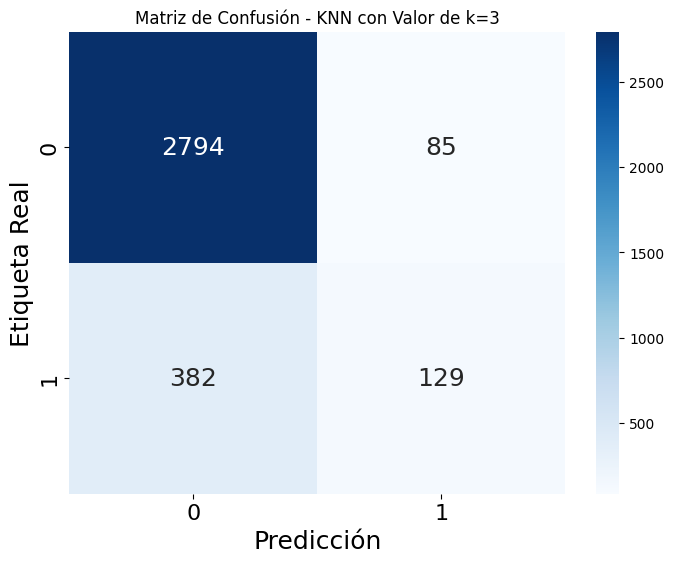

Resultados guardados en 'resultados_predicciones.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar el modelo KNN guardado
with open('knn_model.pkl', 'rb') as f:
    loaded_knn = pickle.load(f)

print("Modelo KNN cargado exitosamente.")

# 2. Cargar el nuevo CSV con ejemplos para clasificar
nuevo_csv = '/content/drive/My Drive/IA - Nosotros Robot/TEST2_cardiovascular_risk.csv'  # Cambia al nombre correcto del archivo
data_nueva = pd.read_csv(nuevo_csv)

# 3. Quitar la columna objetivo 'TenYearCHD' para predicción y guardar etiquetas reales
y_real = data_nueva['TenYearCHD']  # Guardar etiquetas reales para evaluación
X_nueva = data_nueva.drop('TenYearCHD', axis=1)

# 4. Convertir las columnas categóricas ('sex' y 'is_smoking') a numéricas
X_nueva['sex'] = X_nueva['sex'].map({'M': 1, 'F': 0})
X_nueva['is_smoking'] = X_nueva['is_smoking'].map({'YES': 1, 'NO': 0})

# 5. Asegurarse de que 'id' no esté presente en los datos de predicción
if 'id' in X_nueva.columns:
    X_nueva = X_nueva.drop('id', axis=1)

# Verificar las columnas para asegurar que coinciden con las del entrenamiento
print(f"Columnas del nuevo CSV: {X_nueva.columns}")

# 6. Normalizar los datos con StandardScaler
scaler = StandardScaler()
X_nueva_scaled = scaler.fit_transform(X_nueva)  # Escalar los datos de predicción

# 7. Hacer predicciones usando el modelo KNN cargado
y_pred = loaded_knn.predict(X_nueva_scaled)

# 8. Evaluar la precisión comparando las predicciones con las etiquetas reales
accuracy = accuracy_score(y_real, y_pred)
print(f'Precisión en el nuevo CSV: {accuracy:.2f}')

# 9. Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_real, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18})
plt.title('Matriz de Confusión - KNN con Valor de k=3')
plt.xlabel('Predicción', fontsize=18)
plt.ylabel('Etiqueta Real', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# 10. Crear un nuevo CSV con las predicciones y las etiquetas reales
resultados = pd.DataFrame({'Predicción': y_pred, 'Etiqueta Real': y_real})
resultados.to_csv('resultados_predicciones.csv', index=False)
print("Resultados guardados en 'resultados_predicciones.csv'.")

# Opcional: Descargar el CSV generado en Google Colab
from google.colab import files
files.download('resultados_predicciones.csv')


## Buscar k optimo

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# 1. Cargar el modelo KNN guardado
with open('knn_model.pkl', 'rb') as f:
    knn = pickle.load(f)

# 2. Definir un rango de valores de k para probar
k_range = range(1, 11)  # Probar k de 1 a 10
best_k = 1
best_f1 = 0

# Lista para almacenar las métricas de cada k
metricas_k = []

# 3. Probar cada valor de k y evaluar con el conjunto de prueba
for k in k_range:
    # Actualizar el valor de k en el modelo KNN
    knn.k = k

    # Predecir con el modelo usando el conjunto de prueba
    y_pred = knn.predict(X_test_scaled)

    # Calcular el reporte de clasificación
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['1']['f1-score']  # F1-Score de la clase 1 (Con Riesgo)

    # Almacenar las métricas en la lista
    metricas_k.append({
        'k': k,
        'Precisión Global': accuracy_score(y_test, y_pred),
        'Precisión Clase 0': report['0']['precision'],
        'Precisión Clase 1': report['1']['precision'],
        'Recall Clase 0': report['0']['recall'],
        'Recall Clase 1': report['1']['recall'],
        'F1-Score Clase 0': report['0']['f1-score'],
        'F1-Score Clase 1': report['1']['f1-score']
    })

    print(f"Valor de k: {k}, F1-Score Clase 1 (Con Riesgo): {f1:.2f}")

    # Guardar el mejor valor de k basado en F1-Score para la clase 1
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"\nMejor valor de k: {best_k} con F1-Score para Clase 1: {best_f1:.2f}")

# 4. Evaluar el modelo con el mejor valor de k
knn.k = best_k  # Asignar el mejor k encontrado
y_pred_best_k = knn.predict(X_test_scaled)

# Mostrar el reporte de clasificación final con nombres personalizados
print("\nReporte de Clasificación con el mejor k:")
print(classification_report(y_test, y_pred_best_k, target_names=['Sin Riesgo', 'Con Riesgo']))

# Calcular y mostrar la precisión final
accuracy = accuracy_score(y_test, y_pred_best_k)
print(f"\nPrecisión con el mejor k ({best_k}): {accuracy:.2f}")

# 5. Convertir las métricas en un DataFrame para una tabla de resultados
df_metricas_k = pd.DataFrame(metricas_k)
print("\nTabla de métricas para cada k:")
print(df_metricas_k)

# Opcional: Guardar la tabla de métricas como CSV
df_metricas_k.to_csv('/content/metricas_por_k.csv', index=False)
print("\nMétricas guardadas exitosamente como 'metricas_por_k.csv'.")




Valor de k: 1, F1-Score Clase 1 (Con Riesgo): 0.21
Valor de k: 2, F1-Score Clase 1 (Con Riesgo): 0.21
Valor de k: 3, F1-Score Clase 1 (Con Riesgo): 0.19
Valor de k: 4, F1-Score Clase 1 (Con Riesgo): 0.16
Valor de k: 5, F1-Score Clase 1 (Con Riesgo): 0.12
Valor de k: 6, F1-Score Clase 1 (Con Riesgo): 0.09
Valor de k: 7, F1-Score Clase 1 (Con Riesgo): 0.06
Valor de k: 8, F1-Score Clase 1 (Con Riesgo): 0.09
Valor de k: 9, F1-Score Clase 1 (Con Riesgo): 0.05
Valor de k: 10, F1-Score Clase 1 (Con Riesgo): 0.04

Mejor valor de k: 1 con F1-Score para Clase 1: 0.21

Reporte de Clasificación con el mejor k:
              precision    recall  f1-score   support

  Sin Riesgo       0.86      0.89      0.87       864
  Con Riesgo       0.23      0.20      0.21       153

    accuracy                           0.78      1017
   macro avg       0.55      0.54      0.54      1017
weighted avg       0.77      0.78      0.77      1017


Precisión con el mejor k (1): 0.78

Tabla de métricas para cada k:


Precisión del modelo KNN (propio): 0.83


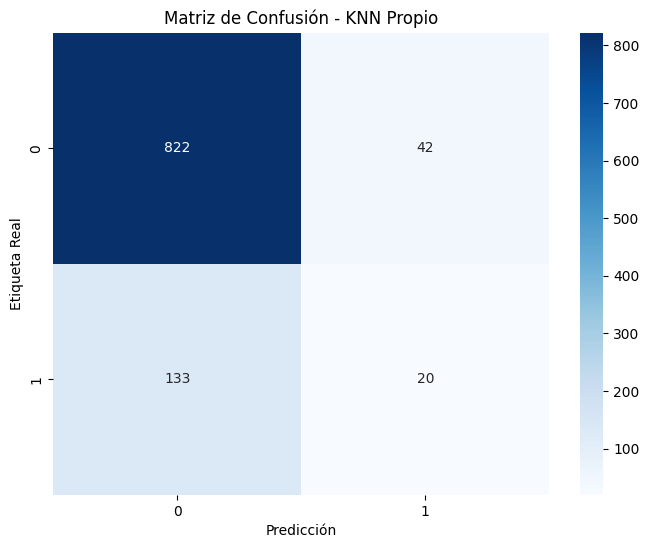


Precisión del modelo KNN (sklearn): 0.84


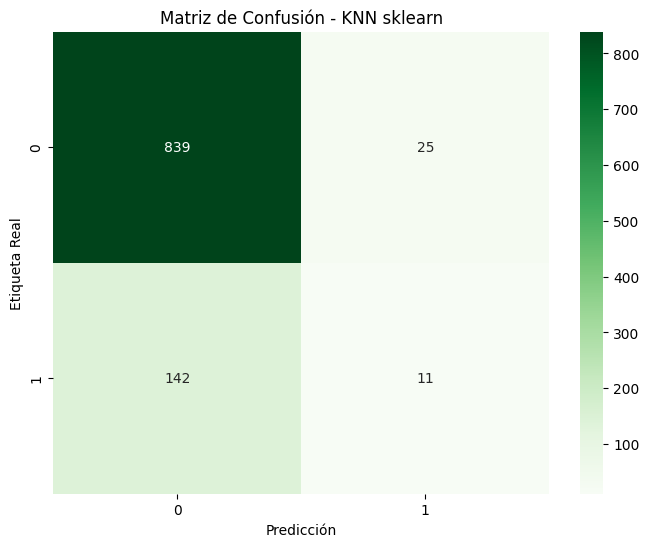


Precisión del modelo Decision Tree: 0.76


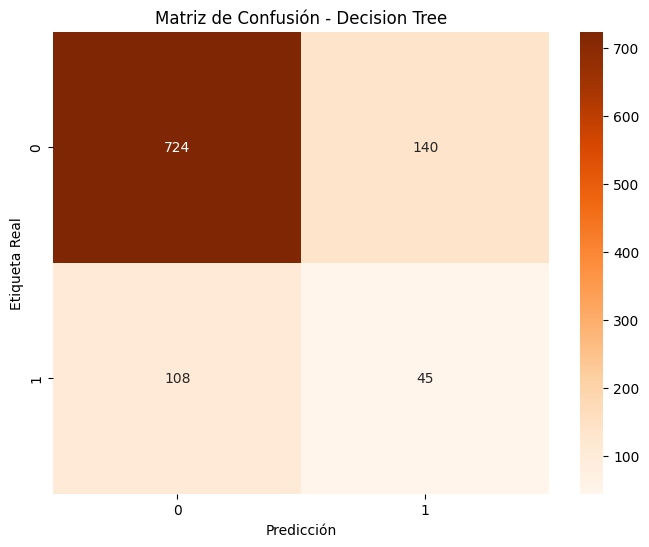


Modelos guardados exitosamente.


In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import csv
import pickle

# 1. Cargar el archivo CSV
data = pd.read_csv('/content/drive/My Drive/IA - Nosotros Robot/data_cardiovascular_imputado.csv')

# Crear un archivo de log para guardar filas con problemas
log_filename = 'log_errores.csv'
logfile = open(log_filename, mode='w', newline='')
logwriter = csv.writer(logfile)
logwriter.writerow(['Fila', 'Error'])  # Escribir encabezado en el archivo de log

# 2. Limpiar y procesar los datos con manejo de errores
data_clean = []
for idx, row in data.iterrows():
    try:
        # Convertir variables categóricas a numéricas
        row['sex'] = 1 if row['sex'] == 'M' else 0
        row['is_smoking'] = 1 if row['is_smoking'] == 'YES' else 0
        # Verificar si hay datos faltantes
        if row.isnull().any():
            raise ValueError("Datos faltantes en la fila")
        data_clean.append(row)
    except Exception as e:
        logwriter.writerow([idx, str(e)])  # Registrar el error en el log
        continue  # Continuar con la siguiente fila

logfile.close()  # Cerrar el archivo de log después de procesar los datos

# Convertir la lista data_clean en un DataFrame
data_clean = pd.DataFrame(data_clean)

# 3. Definir características y variable objetivo
X = data_clean[['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
                'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
                'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]
y = data_clean['TenYearCHD']

# 4. Dividir en conjunto de entrenamiento y prueba usando estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 5. Normalizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Implementación del algoritmo KNN desde cero

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train.iloc[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# 7. Crear y entrenar el modelo KNN manual con k=3
knn_manual = KNN(k=3)
knn_manual.fit(X_train_scaled, y_train)

# 8. Predecir y evaluar el modelo KNN manual
y_pred_manual = knn_manual.predict(X_test_scaled)
accuracy_manual = accuracy_score(y_test, y_pred_manual)
print(f'\nPrecisión del modelo KNN (propio): {accuracy_manual:.2f}')

# Matriz de confusión para el KNN manual
conf_matrix_manual = confusion_matrix(y_test, y_pred_manual)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_manual, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - KNN Propio')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# 9. Implementación del KNN usando la librería sklearn
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
knn_sklearn.fit(X_train_scaled, y_train)
y_pred_sklearn = knn_sklearn.predict(X_test_scaled)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f'\nPrecisión del modelo KNN (sklearn): {accuracy_sklearn:.2f}')

# Matriz de confusión para el KNN de sklearn
conf_matrix_sklearn = confusion_matrix(y_test, y_pred_sklearn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sklearn, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - KNN sklearn')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# 10. Implementación del modelo de Decision Tree usando sklearn
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'\nPrecisión del modelo Decision Tree: {accuracy_dt:.2f}')

# Matriz de confusión para el Decision Tree
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - Decision Tree')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()
